In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation
from keras import backend as K

In [3]:
training_path = "/kaggle/input/digit-recognizer/train.csv"
testing_path = "/kaggle/input/digit-recognizer/test.csv"

epoch = 100
batchsize = 64
image_size = 28
image_size_pad = 32

In [4]:
data = pd.read_csv(training_path)
data.head()

data_test = pd.read_csv(testing_path)
data_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_train = data.loc[:, "label"]
x_train = data.iloc[:, 1:]

x_test = data_test.iloc[:, :]

print("Training set:", x_train.shape)
print("Training set labels:", y_train.shape)

print("Testing set:", x_test.shape)

Training set: (42000, 784)
Training set labels: (42000,)
Testing set: (28000, 784)


In [6]:
x_train = x_train.values.reshape(-1, image_size, image_size, 1)
x_test = x_test.values.reshape(-1, image_size, image_size, 1)

print(x_train.shape)
print(x_test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


1


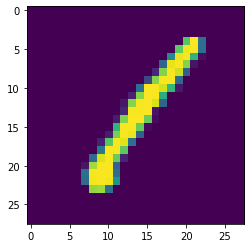

In [7]:
plt.imshow(x_train[0])
print(y_train[0])

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
#做padding，使符合32x32 (為了符合LeNet)

x_train = tf.pad(x_train,[[0,0],[2,2],[2,2],[0,0]])
x_test = tf.pad(x_test,[[0,0],[2,2],[2,2],[0,0]])

In [10]:
print(x_train.shape)

(42000, 32, 32, 1)


In [11]:
num = x_train.shape[0] // 10
train_data, val_data = tf.split(x_train,[num*9, num])
train_label, val_label = tf.split(y_train,[num*9, num])

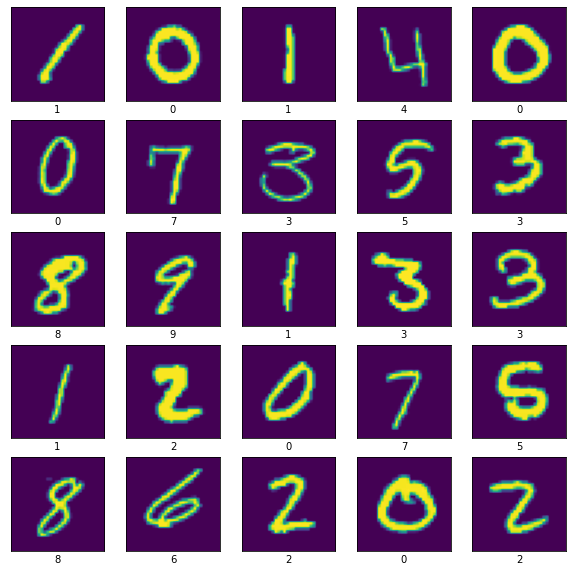

In [12]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_data[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train_label[i].numpy())

In [13]:
# 不做one-hot encoding
# train_label = keras.utils.to_categorical(train_label)
# val_label = keras.utils.to_categorical(val_label)

# print(train_label[0])

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data,train_label)).shuffle(33600,seed=42).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((val_data,val_label)).shuffle(33600,seed=42).batch(128)

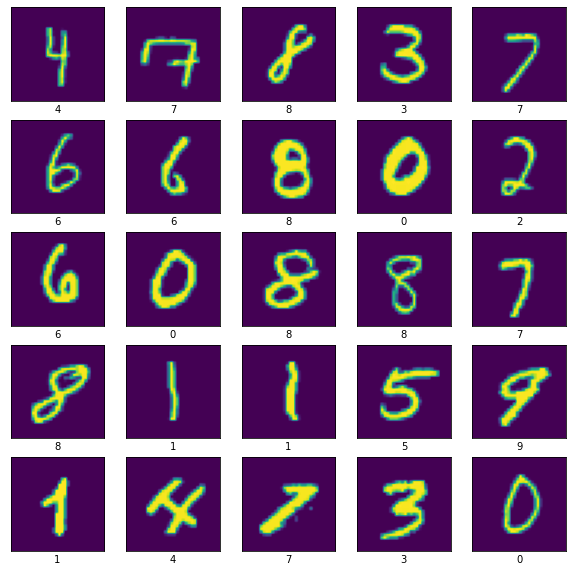

In [15]:
plt.figure(figsize=(10,10))

for image,label in train_ds.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(image[i])
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(label[i].numpy())

## from Digit Recognizer Accuracy 99.3%
https://www.kaggle.com/greynolan/digit-recognizer-accuracy-99-3

使用 
- LeNet-style neural network
- Monte-Carlo Dropout
- SparseCategoricalCrossentropy

### LeNet (1998)

LeNet 是由 Yann LeCun 團隊提出的網路架構，是卷積神經網路的始祖。

其架構由**兩個卷積層、池化層、全連接層以及最後一層 Gaussian 連接層所組成**，早期用來辨識手寫數字圖像

由下圖可以看到 LeNet 的網路架構共有七層：
- 卷積層 (Convolutions, C1)、
- 池化層 (Subsampling, S2)、
- 卷積層 (C3)、池化層 (S4)、
- 全連接卷積層 (C5)、
- 全連接層 (F6)、
- Gaussian 連接層 (output)

![Alt text](https://miro.medium.com/max/1010/1*hulTsO-BPGXn5nXnvVXQMA.png)

輸入層是一個 32x32 的圖片，而 Filter size 皆為 5x5，第一個 Filter 與第二個 Filter 的輸出通道分別為 6、16，並且皆使用 Sigmoid 作為激活函數。

池化層的窗口為 2x2，stride 為 2，使用平均池化進行採樣。最後的全連接層的神經元數量分別是 120、84 個。

最後一層輸出層是 Gaussian連接層，採用 RBF 函數 (radial basis function, 徑向歐式距離函數)，計算輸入向量和參數向量之間的歐式距離。因為 LeNet 應用於辨識手寫圖像，數字為0~9，所以輸出層為 10 個神經元

from: https://medium.com/ching-i/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1-cnn-%E7%B6%93%E5%85%B8%E6%A8%A1%E5%9E%8B-lenet-alexnet-vgg-nin-with-pytorch-code-84462d6cf60c

In [16]:
# Use Monte-Carlo Dropout to reduce overfitting
class MCDropout(layers.Dropout):
    def call(self,inputs):
        return super().call(inputs,training=True)

In [17]:
inputs = layers.Input(shape=(image_size_pad, image_size_pad, 1))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.MaxPooling2D(2,strides=2)(x)
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.MaxPooling2D(2,strides=2)(x)
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(84,activation='relu')(x)
x = MCDropout(0.1)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         409728

In [18]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam', 
              metrics=['accuracy'])

In [19]:
# Using EarlyStopping, end training when val_accuracy is not improved for 10 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                    patience=10,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 5 consecutive times
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5,patience=5)

In [20]:
h = model.fit(train_ds, epochs=epoch, 
              batch_size=batchsize, verbose=1, 
              validation_data=val_ds)

Epoch 1/100
296/296 [==============================] - 6s 11ms/step - loss: 0.4914 - accuracy: 0.8399 - val_loss: 0.0768 - val_accuracy: 0.9740
Epoch 2/100
296/296 [==============================] - 3s 9ms/step - loss: 0.0589 - accuracy: 0.9815 - val_loss: 0.0459 - val_accuracy: 0.9843
Epoch 3/100
296/296 [==============================] - 3s 9ms/step - loss: 0.0370 - accuracy: 0.9880 - val_loss: 0.0374 - val_accuracy: 0.9879
Epoch 4/100
296/296 [==============================] - 3s 9ms/step - loss: 0.0252 - accuracy: 0.9916 - val_loss: 0.0329 - val_accuracy: 0.9900
Epoch 5/100
296/296 [==============================] - 3s 9ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.0317 - val_accuracy: 0.9910
Epoch 6/100
296/296 [==============================] - 3s 9ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0320 - val_accuracy: 0.9905
Epoch 7/100
296/296 [==============================] - 3s 9ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0315 - val_accuracy: 0.990

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Acc: 1.0
Val Acc: 0.9921428561210632


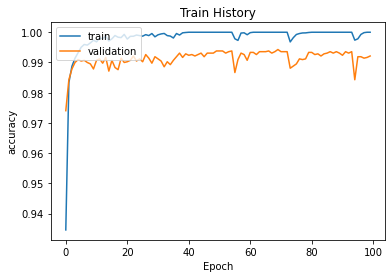

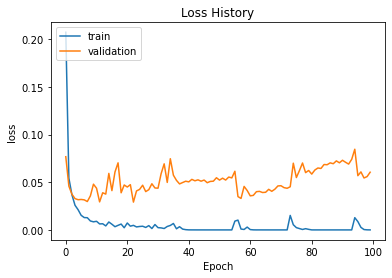

In [21]:
print(h.history.keys())
print("Acc:", h.history['accuracy'][-1])
print("Val Acc:", h.history['val_accuracy'][-1])

def show_train_history(train_history, train, validation, title):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title(title)  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show() 

show_train_history(h, 'accuracy', 'val_accuracy', 'Train History') 
show_train_history(h, 'loss', 'val_loss', 'Loss History')  

In [22]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis=1)

print(predictions[:5])

[2 0 9 9 3]


In [23]:
ids = range(1, (len(predictions)+1))

submission = pd.DataFrame({
    "ImageId": ids, 
    "Label": predictions,
})

submission.to_csv("submission.csv", index = False)